In [1]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 41.0 MB/s eta 0:00:00


In [2]:
dataset_path = "/kaggle/input/flickr8k/Images/"

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import faiss
import os
import tensorflow as tf
from tensorflow.keras import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
image_path = os.listdir(dataset_path)
image_df = pd.Series(image_path)
image_df = pd.DataFrame(image_df)
image_df.columns = ["file_name"]
image_df.head()

,file_name
0,3226254560_2f8ac147ea.jpg
1,214543992_ce6c0d9f9b.jpg
2,2366643786_9c9a830db8.jpg
3,3368819708_0bfa0808f8.jpg
4,2190227737_6e0bde2623.jpg


In [5]:
image_df.shape

(8091, 1)

In [6]:
image_df.to_csv("image_df.csv")

In [7]:
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(512,512,3)

)

model=Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
])

model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [8]:
def extract_feature_vector(file_name, model):
    path = dataset_path + file_name
    img = cv2.imread(path)
    img = cv2.resize(img, (512, 512))
    a = []
    a.append(img)
    a = np.array(a)
    pred = model.predict(a, verbose=None)
    return pred[0]


In [9]:
xb = []
for i in range(image_df.shape[0]):
    xb.append(extract_feature_vector(image_df["file_name"][i], model))
xb = np.array(xb)


In [10]:
image_df.shape[0]

8091

In [11]:
xb.shape

(8091, 2048)

In [12]:
np.save("feature_vectors.npy", xb)

In [13]:
index = faiss.IndexFlatL2(2048)
index.add(xb)
print(index.ntotal)

8091


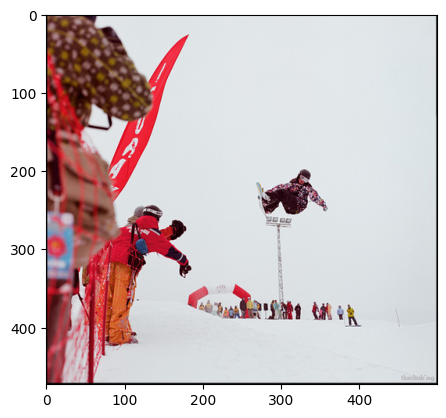

In [14]:
img = cv2.imread(dataset_path + image_df["file_name"][10])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [15]:
xq = []
xq.append(extract_feature_vector(image_df["file_name"][10], model))
xq = np.array(xq)

In [16]:
D, I = index.search(xq, 15)


In [17]:
I

array([[  10, 5179, 4832, 1662, 5933,  105, 6892, 6583, 5481, 3787,  823,
        5335, 7423, 5960, 5356]])

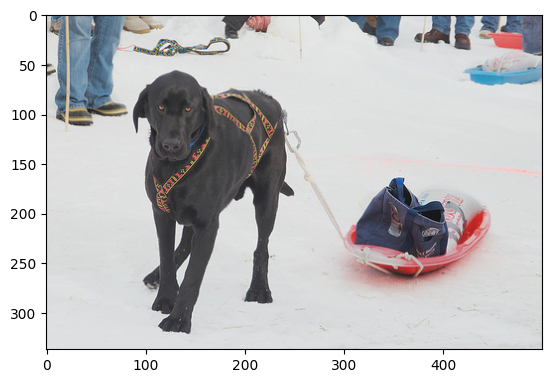

In [18]:
img = cv2.imread(dataset_path + image_df["file_name"][I[0][4]])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)